In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)


In [ ]:
df = pd.read_csv("../jigsaw-toxic-comment-train.csv")
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [ ]:
#loading dataset
df = pd.read_csv("../jigsaw-toxic-comment-train.csv")
df = df.drop("id",axis="columns")
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
label_occurs = []
for type in label_cols:
    occurence = len(df[df[type]==1])
    label_occurs.append(occurence)
    print(type,occurence)

toxic 21384
severe_toxic 1962
obscene 12140
threat 689
insult 11304
identity_hate 2117


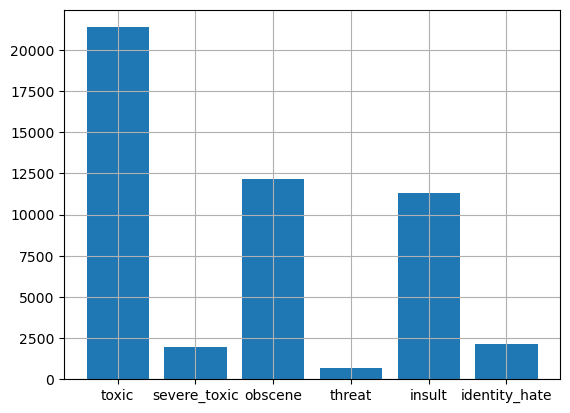

In [18]:
plt.bar(label_cols,label_occurs,label = label_cols)
plt.grid()
plt.show()

In [9]:
#loading dataset
df = pd.read_csv("../jigsaw-toxic-comment-train.csv")
df = df.drop("id",axis="columns")
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df["labels"] = df[label_cols].values.tolist()
df = df.head(2000)

In [10]:

label_occurs = []
for type in label_cols:
    occurence = len(df[df[type]==1])
    label_occurs.append(occurence)
    print(type,occurence)

toxic 199
severe_toxic 20
obscene 101
threat 9
insult 104
identity_hate 22


In [4]:
#Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment_text"].tolist(),
    df["labels"].tolist(),
    test_size=0.2,
    random_state=42
)

len(train_texts), len(val_texts)

(1600, 400)

In [5]:
#Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

train_encodings

{'input_ids': [[101, 7148, 7011, 12260, 1005, 1055, 5227, 2005, 1037, 5160, 2096, 2108, 6970, 26565, 2006, 13292, 1012, 1019, 2001, 4188, 1010, 2004, 2001, 2010, 5227, 2008, 2002, 2022, 3039, 2000, 2655, 2010, 2269, 1012, 3931, 15028, 8282, 2001, 6380, 2833, 1010, 2300, 1010, 5723, 7807, 1998, 18996, 2015, 2076, 1996, 2035, 2305, 16871, 2006, 13292, 1012, 1019, 1011, 1020, 1012, 1012, 3931, 16528, 15536, 3211, 2094, 1024, 2941, 1010, 2085, 2559, 2012, 4028, 1999, 3304, 1010, 1045, 2156, 2008, 2045, 2003, 1037, 10228, 1997, 3176, 2592, 2055, 2119, 8282, 1998, 7148, 7011, 12260, 1005, 1055, 16871, 2015, 2008, 2071, 2022, 2443, 1012, 2061, 1045, 2097, 2147, 2006, 10328, 2035, 2008, 1999, 2062, 6987, 4826, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1000, 1027, 1027, 3972, 20624, 2239, 1997, 4070, 1027, 1027, 7929, 2630, 11097, 1010, 1000, 1000, 9260, 2013, 1048, 21486, 1043, 2692, 3070, 1048, 23632, 2038, 2042, 9776, 2011, 2630, 11097, 2683, 2575, 2005, 1996, 2206, 3114, 1006, 1

In [6]:
# Torch Dataset wrapper
class CyberbullyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset = CyberbullyDataset(train_encodings, train_labels)
val_dataset = CyberbullyDataset(val_encodings, val_labels)

In [7]:
#Load BERT model for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#Define metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    labels = labels.astype(int)
    
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    
    return {"accuracy": acc, "macro_precision": p, "macro_recall": r, "macro_f1": f1}


In [10]:
#  Cell 9: Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\BOYA RAVI KUMAR\AppData\Local\Temp\ipykernel_24456\2676715353.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
#Train model
trainer.train()

C:\Users\BOYA RAVI KUMAR\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,0.136004,0.860000,0.136364,0.061224,0.084507
2,No log,0.112204,0.880000,0.457071,0.206829,0.281290


C:\Users\BOYA RAVI KUMAR\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=200, training_loss=0.17037841796875, metrics={'train_runtime': 1931.1683, 'train_samples_per_second': 1.657, 'train_steps_per_second': 0.104, 'total_flos': 210496403865600.0, 'train_loss': 0.17037841796875, 'epoch': 2.0})

In [12]:
trainer.save_model("./best_model")  # Saves model + tokenizer + config
tokenizer.save_pretrained("./best_model")


('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')

In [13]:
#Evaluate on validation set
metrics = trainer.evaluate()
metrics


C:\Users\BOYA RAVI KUMAR\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.11220400035381317,
 'eval_accuracy': 0.88,
 'eval_macro_precision': 0.4570707070707071,
 'eval_macro_recall': 0.20682888540031397,
 'eval_macro_f1': 0.28128960787188634,
 'eval_runtime': 53.6274,
 'eval_samples_per_second': 7.459,
 'eval_steps_per_second': 0.466,
 'epoch': 2.0}

In [52]:
#Example inference
test_texts = ["You are a great person!"]
encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
outputs = model(**encodings)
print(outputs)
probs = torch.sigmoid(outputs.logits).detach().numpy()

for text, prob in zip(test_texts, probs):
    print(f"\nText: {text}")
    for lbl, score in zip(label_cols, prob):
        print(f"{lbl}: {score:.3f}")


SequenceClassifierOutput(loss=None, logits=tensor([[-1.7989, -3.2933, -3.0230, -3.0334, -2.7854, -3.0147]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Text: You are a great person!
toxic: 0.142
severe_toxic: 0.036
obscene: 0.046
threat: 0.046
insult: 0.058
identity_hate: 0.047
